In [436]:
import os
import re
import string
import random
from glob import glob
from argparse import Namespace

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf

2.10.0


In [437]:
import wandb
from wandb.keras import WandbMetricsLogger
from wandb.keras import WandbModelCheckpoint

In [444]:
def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

random_id = id_generator(size=8)
print('Experiment Id: ', random_id)


configs = Namespace(
    num_frames = 32,
    batch_size = 128,
    epochs = 60,
    resizing_interpolation = "nearest",
    learning_rate = 1e-3,
    num_steps = 1.0,
    experiment_id = random_id,
    num_jcd_features = 3321, # ((82*82)-82)/2
    num_classes = 250,
    filters = 256,
)


LIP = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]

RIGHT_EYE = [
    246, 161, 160, 159, 158, 157, 173,
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    247, 30, 29, 27, 28, 56, 190,
    130, 25, 110, 24, 23, 22, 26, 112, 243,
    113, 225, 224, 223, 222, 221, 189,
    226, 31, 228, 229, 230, 231, 232, 233, 244,
    143, 111, 117, 118, 119, 120, 121, 128, 245,
]

LEFT_EYE = [
    466, 387, 386, 385, 384, 398,
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    467, 260, 259, 257, 258, 286, 414,
    359, 255, 339, 254, 253, 252, 256, 341, 463,
    342, 445, 444, 443, 442, 441, 413,
    446, 261, 448, 449, 450, 451, 452, 453, 464,
    372, 340, 346, 347, 348, 349, 350, 357, 465,
]

Experiment Id:  BTZNAQAM


In [445]:
data_path = "../data/tfrecords"


def natural_keys(text):
    ""
    def atoi(text):
        return int(text) if text.isdigit() else text
    
    return [atoi(c) for c in re.split(r'(\d+)', text)]

tfrecords = sorted(glob(f"{data_path}/*.tfrec"), key=natural_keys)
len(tfrecords)

24

In [446]:
train_tfrecords, valid_tfrecords = tfrecords[:19], tfrecords[19:]

def parse_sequence(serialized_sequence):
    return tf.io.parse_tensor(
        serialized_sequence,
        out_type=tf.float32,
    )


def parse_tfrecord_fn(example):
    feature_description = {
        "n_frames": tf.io.FixedLenFeature([], tf.float32),
        "frames": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    
    return tf.io.parse_single_example(example, feature_description)


@tf.function
def preprocess_frames(frames):
    """
    In this preprocessing function:
    - Fill NaN values to 0.
    - Use `tf.image.resize` to interpolate.
    """
    frames = tf.where(tf.math.is_nan(frames), 0.0, frames)

    frames = tf.image.resize(
        frames, (configs.num_frames, 543), method=configs.resizing_interpolation
    )

    return frames


def parse_data(example):
    # Parse Frames
    n_frames = example["n_frames"]
    frames = tf.reshape(parse_sequence(example["frames"]), shape=(n_frames, 543, 3))
    frames = preprocess_frames(frames)
    
    # Parse Labels
    label = tf.one_hot(example["label"], depth=250)

    return frames, label


AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.TFRecordDataset(train_tfrecords)
valid_ds = tf.data.TFRecordDataset(valid_tfrecords)

trainloader = (
    train_ds
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .shuffle(1024)
    .map(parse_data, num_parallel_calls=AUTOTUNE)
    .batch(128)
    .prefetch(AUTOTUNE)
)

validloader = (
    valid_ds
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .map(parse_data, num_parallel_calls=AUTOTUNE)
    .batch(128)
    .prefetch(AUTOTUNE)
)

# JCD

In [447]:
def compute_JCD(S_k):
    # S_k shape is (num_frames, num_joints, depth)
    # Compute pairwise euclidean distance 
    d = tf.reduce_sum((tf.expand_dims(S_k, 3)-tf.expand_dims(S_k, 2))**2,4)
    d = tf.sqrt(d)
    
    # Get lower triangle to reduce redundancy
    d = tf.linalg.LinearOperatorLowerTriangular(d).to_dense()
    
    # Extract and flatten lower triangle
    ones = tf.ones_like(d)
    mask_a = tf.linalg.band_part(ones, -1, 0) # Lower triangle mask of 0s and 1s
    mask_b = tf.linalg.band_part(ones, 0, 0)  # Diagonal mask of 0s and 1s
    mask = tf.cast(mask_a - mask_b, dtype=tf.bool) # Desired mask

    jcd = tf.boolean_mask(d, mask)
    
    return jcd

# Motion

M_k_slow = S_k_plus_1 - S_k (k = 1,2,3,...,K-1)

[(S_2-S_1), (S_3-S_2), .....]

M_k_fast = S_k_plus_2 - S_k (k = 1,3,5.....,K-2)

[(S_3-S_1), (S_5-S_3), .....]


S_k is the frame. S_k_plus_1 and S_k_plus_2 are behind/ahead S_k resp.

Part of DDNet model.

In [448]:
def joints_diff(x):
    H, W = x.get_shape()[1], x.get_shape()[2]
    x = tf.subtract(x[:, 1:, ...], x[:, :-1, ...])
    x = tf.image.resize(x, size=[H, W], method="nearest")
    return x


def joints_motion(P, frame_l):
    P_diff_slow = Lambda(lambda x: joints_diff(x))(P)
    P_diff_slow = Reshape((frame_l, -1), name="slow_reshape")(P_diff_slow)

    P_fast = Lambda(lambda x: x[:, ::2, ...])(P)
    P_diff_fast = Lambda(lambda x: joints_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l / 2), -1), name="fast_reshape")(P_diff_fast)

    return P_diff_slow, P_diff_fast

# Model

In [449]:
def get_jcd_embedding(x, filters, num_jcd_features):
    # Project down
    x = EinsumDense("abc,cd->abd", output_shape=(None, num_jcd_features//4), bias_axes="d")(x)
    x = LayerNormalization()(x)
    
    x = EinsumDense("abc,cd->abd", output_shape=(None, num_jcd_features//8), bias_axes="d")(x)
    x = LayerNormalization()(x)
    

    # Local relationship between sequences 
    x = Conv1D(filters, 3, strides=1, dilation_rate=1, padding="same")(x)
    x = LayerNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = Conv1D(filters, 3, strides=2, dilation_rate=1, padding="same")(x)
    x = LayerNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = Conv1D(filters, 3, strides=2, dilation_rate=1, padding="same")(x)
    x = LayerNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(0.1)(x)
    
    return x


def get_slow_motion_embedding(x, filters):    
    # Local relationship between sequences 
    x = Conv1D(filters, 3, strides=1, dilation_rate=1, padding="same")(x)
    x = LayerNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = Conv1D(filters, 3, strides=2, dilation_rate=1, padding="same")(x)
    x = LayerNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = Conv1D(filters, 3, strides=2, dilation_rate=1, padding="same")(x)
    x = LayerNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(0.1)(x)
    
    return x


def get_fast_motion_embedding(x, filters):    
    # Local relationship between sequences 
    x = Conv1D(filters, 3, strides=1, dilation_rate=1, padding="same")(x)
    x = LayerNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = Conv1D(filters, 3, strides=2, dilation_rate=1, padding="same")(x)
    x = LayerNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = Conv1D(filters, 3, strides=1, dilation_rate=1, padding="same")(x)
    x = LayerNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(0.1)(x)
    
    return x

In [454]:
def get_DDNet(num_jcd_features, filters, num_frames):
    inputs = Input(shape=(num_frames, 543, 3))
    
    lip_inputs = tf.gather(inputs, indices=LIP, axis=2)
    left_hand_inputs = inputs[:, :, 468:489, :]
    right_hand_inputs = inputs[:, :,522:,:]
    joints = tf.keras.layers.Concatenate(axis=2)(
        [lip_inputs, right_hand_inputs, left_hand_inputs]
    )
    
    
    # JCD
    jcd = compute_JCD(joints)
    jcd = tf.reshape(jcd, (-1, num_frames, num_jcd_features))
    jcd_embedding = get_jcd_embedding(jcd, 256, num_jcd_features)
    
    # Slow and Fast Motion
    slow_motion, fast_motion = joints_motion(joints, num_frames)
    slow_embedding = get_slow_motion_embedding(slow_motion, 256)
    fast_embedding = get_fast_motion_embedding(fast_motion, 256)
    
    # Merge embeddings
    x = Concatenate()([jcd_embedding, slow_embedding, fast_embedding])
    
    # Learn from the embedding
    x = Conv1D(256, 3, strides=2, dilation_rate=1, padding="same")(x)
    x = LayerNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = Conv1D(256, 3, strides=2, dilation_rate=1, padding="same")(x)
    x = LayerNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = GlobalAveragePooling1D()(x)
    
    x = Dense(250, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [456]:
tf.keras.backend.clear_session()

model = get_DDNet(
    num_jcd_features=configs.num_jcd_features,
    filters=configs.filters,
    num_frames=configs.num_frames
)
    
total_steps = 585*configs.epochs
decay_steps = total_steps*configs.num_steps

cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = configs.learning_rate,
    decay_steps = decay_steps,
    alpha=0.1
)

model.compile(
    tf.keras.optimizers.Adam(cosine_decay_scheduler),
    "binary_crossentropy",
    metrics=["acc"]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 543, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 32, 40, 3)   0           ['input_1[0][0]']                
 a)                                                                                               
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 32, 21, 3)   0           ['input_1[0][0]']                
 icingOpLambda)                                                                               

 conv1d (Conv1D)                (None, 32, 256)      318976      ['layer_normalization_1[0][0]']  
                                                                                                  
 conv1d_3 (Conv1D)              (None, 32, 256)      189184      ['slow_reshape[0][0]']           
                                                                                                  
 conv1d_6 (Conv1D)              (None, 16, 256)      189184      ['fast_reshape[0][0]']           
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 32, 256)     512         ['conv1d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 layer_normalization_5 (LayerNo  (None, 32, 256)     512         ['conv1d_3[0][0]']               
 rmalizati

                                                                                                  
 spatial_dropout1d_5 (SpatialDr  (None, 8, 256)      0           ['re_lu_5[0][0]']                
 opout1D)                                                                                         
                                                                                                  
 spatial_dropout1d_8 (SpatialDr  (None, 8, 256)      0           ['re_lu_8[0][0]']                
 opout1D)                                                                                         
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8, 768)       0           ['spatial_dropout1d_2[0][0]',    
                                                                  'spatial_dropout1d_5[0][0]',    
                                                                  'spatial_dropout1d_8[0][0]']    
          

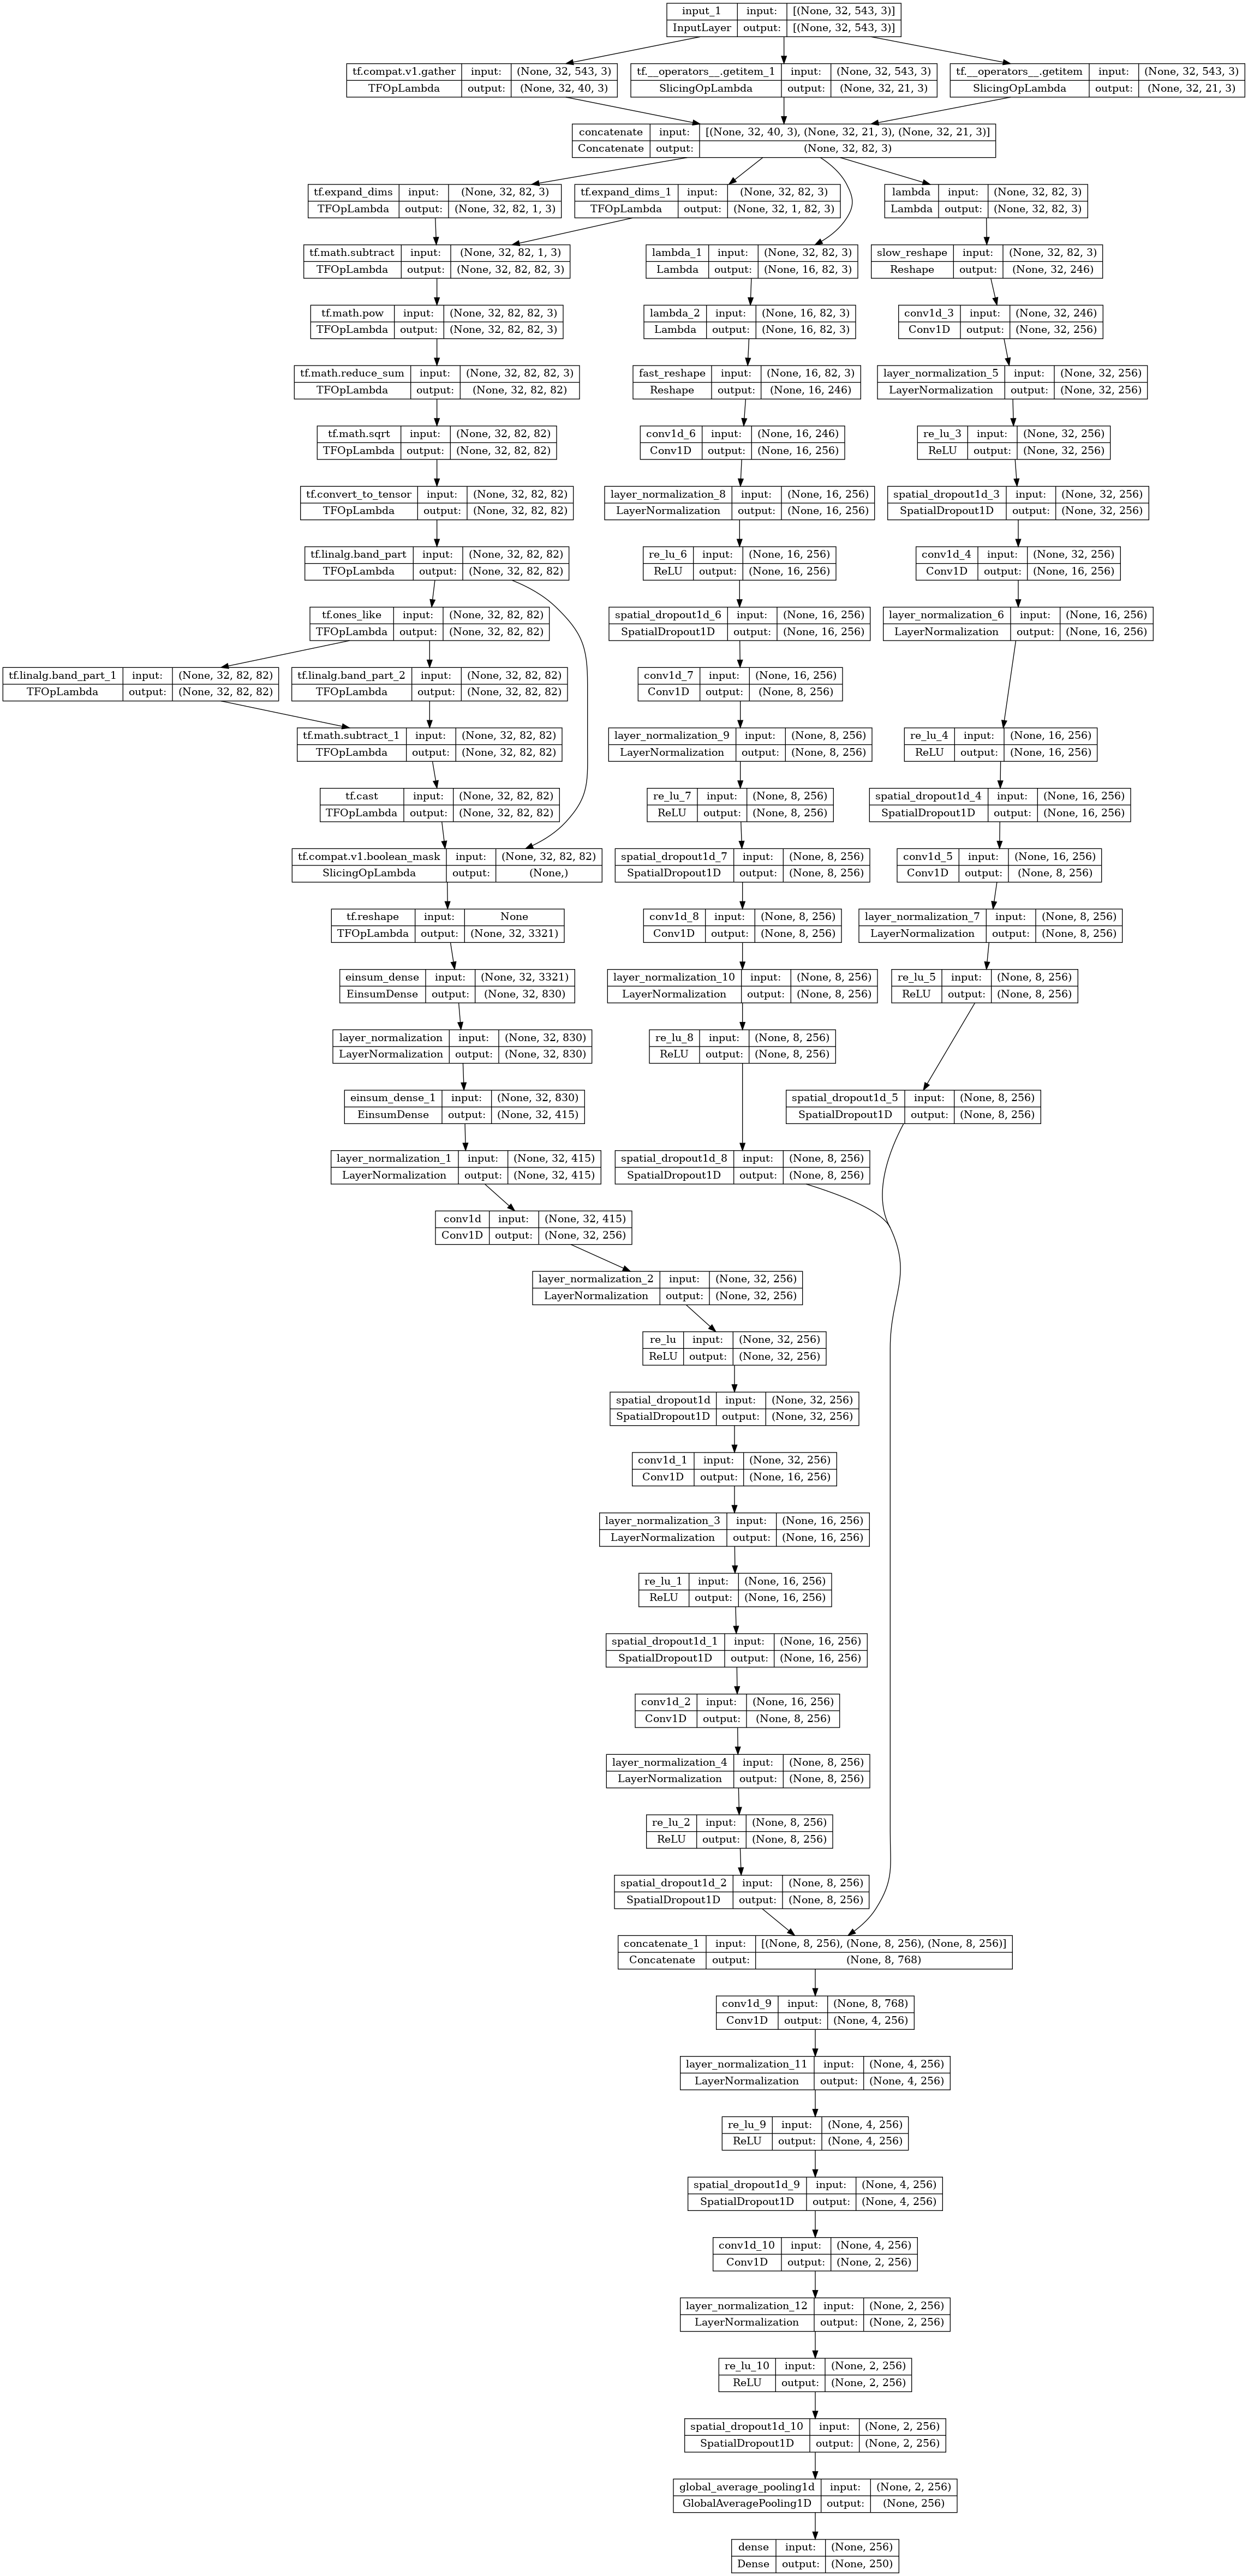

In [457]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [459]:
run = wandb.init(
    project="kaggle-asl",
    name=f"ddnet-{configs.experiment_id}",
    config=configs,
    job_type="train",
)

earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    verbose=0,
    mode="auto",
    restore_best_weights=True,
)

callbacks = [
#     earlystopper,
    WandbMetricsLogger(log_freq=2),
    WandbModelCheckpoint(
        filepath=f"../models/ddnet-{configs.experiment_id}",
        save_best_only=True,
    ),
]

model.fit(
    trainloader,
    epochs=configs.epochs,
    validation_data=validloader,
    callbacks=callbacks,
)

eval_loss, eval_acc = model.evaluate(validloader)
wandb.log({"eval_loss": eval_loss, "eval_acc": eval_acc})

run.finish()

wandb: Currently logged in as: ayush-thakur. Use `wandb login --relogin` to force relogin


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/60
    584/Unknown - 38s 58ms/step - loss: 0.0365 - acc: 0.0034

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 56s 88ms/step - loss: 0.0364 - acc: 0.0034 - val_loss: 0.0261 - val_acc: 0.0038
Epoch 2/60
584/585 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.0033

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 44s 74ms/step - loss: 0.0264 - acc: 0.0033 - val_loss: 0.0261 - val_acc: 0.0043
Epoch 3/60
584/585 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.0026

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0264 - acc: 0.0026 - val_loss: 0.0261 - val_acc: 0.0043
Epoch 4/60
584/585 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.0030

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 53s 90ms/step - loss: 0.0264 - acc: 0.0030 - val_loss: 0.0260 - val_acc: 0.0058
Epoch 5/60
584/585 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.0048

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 52s 88ms/step - loss: 0.0262 - acc: 0.0048 - val_loss: 0.0256 - val_acc: 0.0111
Epoch 6/60
584/585 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.0136

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 52s 89ms/step - loss: 0.0253 - acc: 0.0136 - val_loss: 0.0242 - val_acc: 0.0293
Epoch 7/60
584/585 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.0466

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 51s 87ms/step - loss: 0.0234 - acc: 0.0466 - val_loss: 0.0215 - val_acc: 0.0923
Epoch 8/60
584/585 [============================>.] - ETA: 0s - loss: 0.0211 - acc: 0.1073

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 52s 89ms/step - loss: 0.0211 - acc: 0.1074 - val_loss: 0.0198 - val_acc: 0.1486
Epoch 9/60
584/585 [============================>.] - ETA: 0s - loss: 0.0193 - acc: 0.1678

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 52s 89ms/step - loss: 0.0193 - acc: 0.1679 - val_loss: 0.0183 - val_acc: 0.2093
Epoch 10/60
584/585 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.2248

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 53s 91ms/step - loss: 0.0179 - acc: 0.2248 - val_loss: 0.0172 - val_acc: 0.2512
Epoch 11/60
584/585 [============================>.] - ETA: 0s - loss: 0.0168 - acc: 0.2682

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 53s 90ms/step - loss: 0.0168 - acc: 0.2682 - val_loss: 0.0163 - val_acc: 0.2932
Epoch 12/60
584/585 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.3134

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 52s 89ms/step - loss: 0.0158 - acc: 0.3133 - val_loss: 0.0154 - val_acc: 0.3381
Epoch 13/60
584/585 [============================>.] - ETA: 0s - loss: 0.0150 - acc: 0.3517

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 53s 90ms/step - loss: 0.0150 - acc: 0.3518 - val_loss: 0.0148 - val_acc: 0.3622
Epoch 14/60
584/585 [============================>.] - ETA: 0s - loss: 0.0142 - acc: 0.3869

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.7s


585/585 [==============================] - 51s 87ms/step - loss: 0.0142 - acc: 0.3870 - val_loss: 0.0143 - val_acc: 0.3867
Epoch 15/60
584/585 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.4185

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 51s 86ms/step - loss: 0.0135 - acc: 0.4185 - val_loss: 0.0138 - val_acc: 0.4096
Epoch 16/60
584/585 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.4493

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 53s 90ms/step - loss: 0.0128 - acc: 0.4494 - val_loss: 0.0137 - val_acc: 0.4117
Epoch 17/60
584/585 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.4731

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 52s 89ms/step - loss: 0.0123 - acc: 0.4731 - val_loss: 0.0134 - val_acc: 0.4285
Epoch 18/60
584/585 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.4977

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 52s 88ms/step - loss: 0.0118 - acc: 0.4977 - val_loss: 0.0133 - val_acc: 0.4356
Epoch 19/60
584/585 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.5214

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 53s 90ms/step - loss: 0.0113 - acc: 0.5214 - val_loss: 0.0131 - val_acc: 0.4396
Epoch 20/60
584/585 [============================>.] - ETA: 0s - loss: 0.0108 - acc: 0.5449

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0108 - acc: 0.5450 - val_loss: 0.0132 - val_acc: 0.4370
Epoch 21/60
584/585 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.5668

INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets


INFO:tensorflow:Assets written to: ../models/ddnet-BTZNAQAM/assets
wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 51s 86ms/step - loss: 0.0103 - acc: 0.5669 - val_loss: 0.0129 - val_acc: 0.4533
Epoch 22/60
584/585 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.5848

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0099 - acc: 0.5848 - val_loss: 0.0130 - val_acc: 0.4555
Epoch 23/60
584/585 [============================>.] - ETA: 0s - loss: 0.0095 - acc: 0.6061

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 72ms/step - loss: 0.0095 - acc: 0.6062 - val_loss: 0.0129 - val_acc: 0.4650
Epoch 24/60
584/585 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.6233

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0091 - acc: 0.6233 - val_loss: 0.0131 - val_acc: 0.4648
Epoch 25/60
584/585 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.6421

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 41s 70ms/step - loss: 0.0087 - acc: 0.6421 - val_loss: 0.0131 - val_acc: 0.4655
Epoch 26/60
584/585 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.6576

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 72ms/step - loss: 0.0084 - acc: 0.6577 - val_loss: 0.0131 - val_acc: 0.4665
Epoch 27/60
584/585 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.6757

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0081 - acc: 0.6758 - val_loss: 0.0132 - val_acc: 0.4711
Epoch 28/60
584/585 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.6903

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 41s 70ms/step - loss: 0.0078 - acc: 0.6904 - val_loss: 0.0133 - val_acc: 0.4674
Epoch 29/60
584/585 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.7052

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0075 - acc: 0.7053 - val_loss: 0.0135 - val_acc: 0.4661
Epoch 30/60
584/585 [============================>.] - ETA: 0s - loss: 0.0072 - acc: 0.7192

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0072 - acc: 0.7192 - val_loss: 0.0134 - val_acc: 0.4675
Epoch 31/60
584/585 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.7311

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 41s 70ms/step - loss: 0.0069 - acc: 0.7312 - val_loss: 0.0136 - val_acc: 0.4688
Epoch 32/60
584/585 [============================>.] - ETA: 0s - loss: 0.0067 - acc: 0.7462

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 42s 71ms/step - loss: 0.0067 - acc: 0.7462 - val_loss: 0.0137 - val_acc: 0.4691
Epoch 33/60
584/585 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.7560

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 72ms/step - loss: 0.0065 - acc: 0.7561 - val_loss: 0.0137 - val_acc: 0.4715
Epoch 34/60
584/585 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.7655

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0062 - acc: 0.7655 - val_loss: 0.0140 - val_acc: 0.4677
Epoch 35/60
584/585 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.7770

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 41s 70ms/step - loss: 0.0060 - acc: 0.7769 - val_loss: 0.0140 - val_acc: 0.4739
Epoch 36/60
584/585 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.7848

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 72ms/step - loss: 0.0059 - acc: 0.7849 - val_loss: 0.0141 - val_acc: 0.4747
Epoch 37/60
584/585 [============================>.] - ETA: 0s - loss: 0.0056 - acc: 0.7964

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 72ms/step - loss: 0.0056 - acc: 0.7965 - val_loss: 0.0142 - val_acc: 0.4745
Epoch 38/60
584/585 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.8032

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 41s 70ms/step - loss: 0.0055 - acc: 0.8031 - val_loss: 0.0144 - val_acc: 0.4742
Epoch 39/60
584/585 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.8111

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0053 - acc: 0.8111 - val_loss: 0.0145 - val_acc: 0.4771
Epoch 40/60
584/585 [============================>.] - ETA: 0s - loss: 0.0051 - acc: 0.8204

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0051 - acc: 0.8204 - val_loss: 0.0145 - val_acc: 0.4744
Epoch 41/60
584/585 [============================>.] - ETA: 0s - loss: 0.0050 - acc: 0.8273

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.7s


585/585 [==============================] - 42s 72ms/step - loss: 0.0050 - acc: 0.8272 - val_loss: 0.0146 - val_acc: 0.4791
Epoch 42/60
584/585 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.8345

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 41s 70ms/step - loss: 0.0049 - acc: 0.8346 - val_loss: 0.0148 - val_acc: 0.4777
Epoch 43/60
584/585 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.8405

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 72ms/step - loss: 0.0047 - acc: 0.8405 - val_loss: 0.0149 - val_acc: 0.4780
Epoch 44/60
585/585 [==============================] - ETA: 0s - loss: 0.0046 - acc: 0.8457

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 72ms/step - loss: 0.0046 - acc: 0.8457 - val_loss: 0.0150 - val_acc: 0.4770
Epoch 45/60
584/585 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.8507

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 41s 70ms/step - loss: 0.0045 - acc: 0.8507 - val_loss: 0.0151 - val_acc: 0.4757
Epoch 46/60
584/585 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.8567

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 72ms/step - loss: 0.0044 - acc: 0.8567 - val_loss: 0.0152 - val_acc: 0.4783
Epoch 47/60
584/585 [============================>.] - ETA: 0s - loss: 0.0042 - acc: 0.8601

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 72ms/step - loss: 0.0042 - acc: 0.8601 - val_loss: 0.0152 - val_acc: 0.4792
Epoch 48/60
584/585 [============================>.] - ETA: 0s - loss: 0.0042 - acc: 0.8659

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 41s 70ms/step - loss: 0.0042 - acc: 0.8659 - val_loss: 0.0153 - val_acc: 0.4810
Epoch 49/60
584/585 [============================>.] - ETA: 0s - loss: 0.0041 - acc: 0.8707

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0041 - acc: 0.8708 - val_loss: 0.0154 - val_acc: 0.4786
Epoch 50/60
584/585 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.8733

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 42s 72ms/step - loss: 0.0040 - acc: 0.8734 - val_loss: 0.0154 - val_acc: 0.4758
Epoch 51/60
584/585 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.8761

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0039 - acc: 0.8761 - val_loss: 0.0156 - val_acc: 0.4765
Epoch 52/60
584/585 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.8798

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 41s 70ms/step - loss: 0.0039 - acc: 0.8798 - val_loss: 0.0156 - val_acc: 0.4790
Epoch 53/60
584/585 [============================>.] - ETA: 0s - loss: 0.0038 - acc: 0.8818

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 72ms/step - loss: 0.0038 - acc: 0.8818 - val_loss: 0.0157 - val_acc: 0.4762
Epoch 54/60
584/585 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.8853

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 72ms/step - loss: 0.0037 - acc: 0.8853 - val_loss: 0.0158 - val_acc: 0.4777
Epoch 55/60
584/585 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.8873

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 41s 70ms/step - loss: 0.0037 - acc: 0.8873 - val_loss: 0.0159 - val_acc: 0.4763
Epoch 56/60
584/585 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.8902

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.4s


585/585 [==============================] - 43s 72ms/step - loss: 0.0036 - acc: 0.8902 - val_loss: 0.0159 - val_acc: 0.4772
Epoch 57/60
584/585 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.8902

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 73ms/step - loss: 0.0036 - acc: 0.8902 - val_loss: 0.0159 - val_acc: 0.4804
Epoch 58/60
584/585 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.8936

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 41s 70ms/step - loss: 0.0035 - acc: 0.8936 - val_loss: 0.0159 - val_acc: 0.4779
Epoch 59/60
584/585 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.8956

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


585/585 [==============================] - 43s 72ms/step - loss: 0.0035 - acc: 0.8956 - val_loss: 0.0160 - val_acc: 0.4795
Epoch 60/60
584/585 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.8965

wandb: Adding directory to artifact (./../models/ddnet-BTZNAQAM)... Done. 0.5s


154/154 [==============================] - 7s 42ms/step - loss: 0.0161 - acc: 0.4778


batch/acc,▁▁▁▁▁▂▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
batch/loss,█▆▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/acc,▁▁▁▁▁▂▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch/loss,█▆▆▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_acc,▁▁▁▁▂▃▅▅▆▇▇▇▇▇██████████████████████████
epoch/val_loss,████▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃
eval_acc,▁
